# Projet data - alternative au stage de fin de formation

## G-Research Crypto Forecasting

https://www.kaggle.com/c/g-research-crypto-forecasting

<img src="crypto.png"/>

### Préparation des données

**Important** : Executez le code de la partie 1 `crypto_exploration` avant de continuer.

In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import datetime
import time
%matplotlib inline

In [2]:
def load_data(filename):
    with open("./" + filename + ".pkl", 'rb') as f:
        objects = []
        unpickler = pk.Unpickler(f)
        while True:
            try:
                obj = unpickler.load()
                objects.append(obj)
            except:
                return tuple(objects)
    return tuple()

In [3]:
(df,) = load_data("crypto_df")
(d_assets_1_year,) = load_data("crypto_d_assets_1_year")
df.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


Comparons ce qui est comparable.<br>
La corrélation obtenue à la partie précédente est basée sur les valeurs de fermeture. Or toutes les monnaies n'ont pas les mêmes ordres de grandeur. Une corrélation basée sur le pourcentage de différence d'une minute à l'autre serait plus appropriée.<br>

Nous allons donc introduire le rendement, et plus particulièrement son logarithme. Son calcul est le suivant :<br>
$R(t) = log(\frac{P_{t+dt}}{P_t})$, où $dt$ représente l'intervalle de temps entre les deux valeurs.

In [4]:
def log_return(prices, dt):
    return np.log(prices).diff(periods=dt)

Visualisons cet indicateur sur le **Bitcoin** :

In [5]:
df_bitcoin = d_assets_1_year[1]["Asset_Data"]

In [6]:
def timestamps_to_dates(timestamps):
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]
    datenums = md.date2num(dates)
    plt.xticks(rotation=30)
    xfmt = md.DateFormatter('%Y-%m-%d')
    plt.gca().xaxis.set_major_formatter(xfmt)
    return datenums

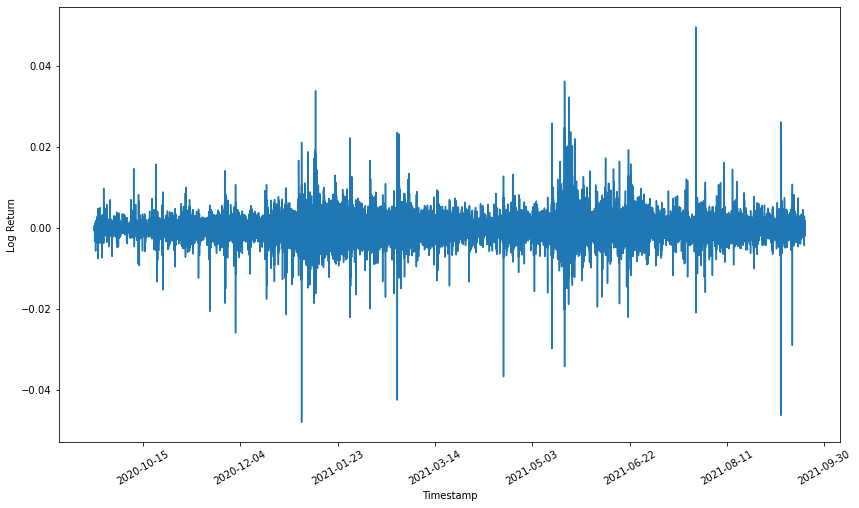

In [7]:
plt.figure(figsize=(14, 8))
plt.plot(timestamps_to_dates(df_bitcoin.index), log_return(df_bitcoin.Close, 1))
plt.xlabel("Timestamp")
plt.ylabel("Log Return")
plt.show()

Nous ne pouvons pas en tirer grand chose... sauf si nous comparons les valeurs de chaque monnaie entre elles.<br>
Pour un souci de visualisation, nous ne prendrons ici que quelques crypto-monnaies :
- Bitcoin
- Ethereum
- Litecoin

In [8]:
def get_corr_log_return(df1, df2, period):
    log_return_df1 = log_return(df1.Close, 1).rename("log_return_df1")
    log_return_df2 = log_return(df2.Close, 1).rename("log_return_df2")
    corr_log_return = pd.concat([log_return_df1, log_return_df2], axis=1)
    corr_log_return = corr_log_return.groupby(corr_log_return.index // period).corr()["log_return_df1"].loc[:,"log_return_df2"]
    return corr_log_return

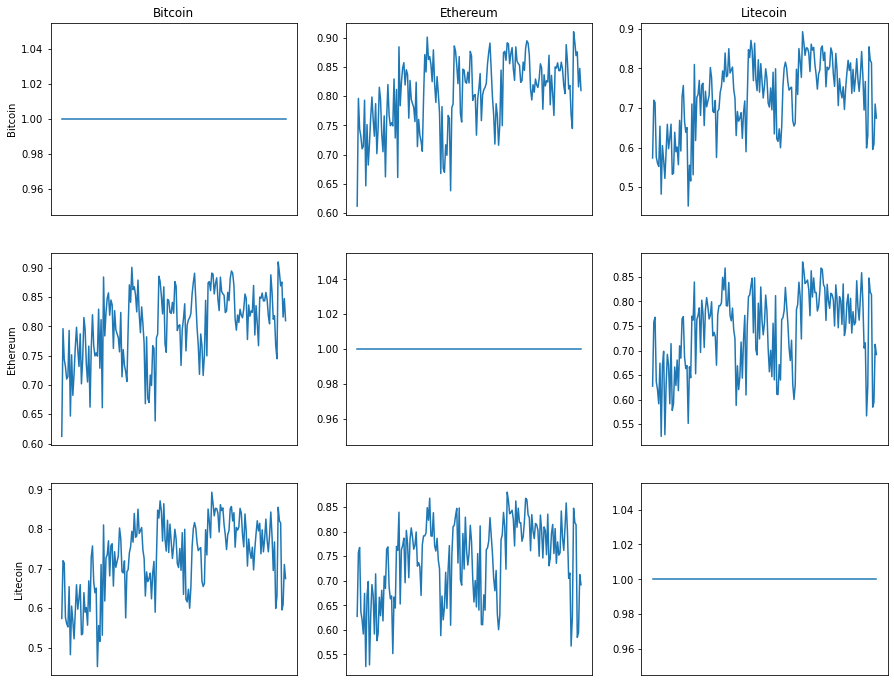

In [9]:
dfs = [d_assets_1_year[1], d_assets_1_year[6], d_assets_1_year[9]]
plt.figure(figsize=(15, 12))
for i in range(3):
    for j in range(3):
        dfi = dfs[i]
        dfj = dfs[j]
        period = 172800 # 2 days
        corr_log_return = get_corr_log_return(dfi["Asset_Data"], dfj["Asset_Data"], period)
        plt.subplot(3, 3, i * 3 + j + 1)
        plt.plot(timestamps_to_dates(corr_log_return.index * period), corr_log_return)
        plt.xticks([])
        if i == 0: plt.title(dfj["Asset_Name"])
        if j == 0: plt.ylabel(dfi["Asset_Name"])
plt.show()

Malgré les variations importantes, la corrélation des rendements de chaque crypto-monnaie est toutefois élevée, jusqu'à **90%** entre le Bitcoin et l'Ethereum !<br>
Nous pouvons maintenant visualiser la corrélation entre les variations de toutes les crypto-monnaies grâce à une matrice de corrélation.

In [10]:
df_assets_1_year = pd.DataFrame()
for asset in d_assets_1_year.values():
    df_assets_1_year = df_assets_1_year.join(log_return(asset["Asset_Data"].Close, 1), rsuffix=asset["Asset_Name"], how="outer")
df_assets_1_year.columns = [asset["Asset_Name"] for asset in d_assets_1_year.values()]
df_assets_1_year.head(5)

,Bitcoin Cash,Binance Coin,Bitcoin,EOS.IO,Ethereum Classic,Ethereum,Litecoin,Monero,TRON,Stellar,Cardano,IOTA,Maker,Dogecoin
timestamp,,,,,,,,,,,,,,
1600552800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1600552860,0.000021,0.000588,-0.000371,0.000065,0.059920,-0.000419,-0.000357,-0.000476,0.001284,0.000163,-0.000663,-0.000367,0.000055,-0.000429
1600552920,-0.000332,-0.001727,-0.000701,-0.000371,-0.017167,-0.001632,-0.000310,0.000095,-0.001619,-0.000813,-0.000645,-0.001651,-0.000298,-0.000125
1600552980,-0.000107,-0.000961,-0.000009,-0.000195,0.015130,0.000583,-0.000517,0.000000,0.000329,-0.002223,0.000483,0.000000,-0.000019,0.000948
1600553040,-0.000086,0.000279,0.000248,0.000254,-0.066736,0.000152,0.000564,-0.000625,0.000592,-0.000788,-0.000393,0.000000,0.000044,0.000429


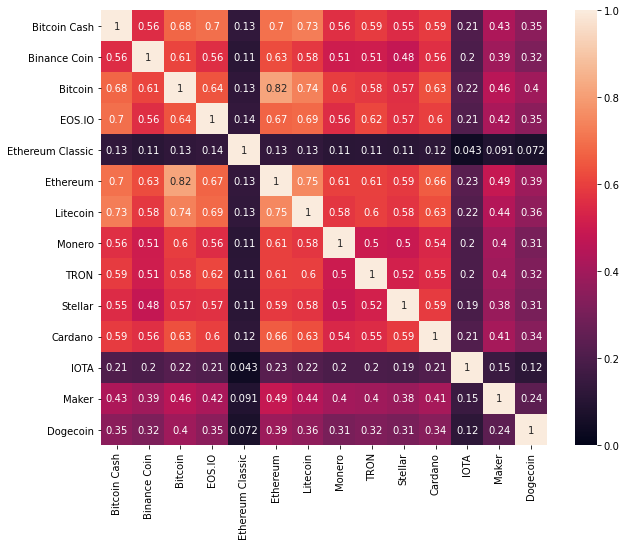

In [11]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_assets_1_year.corr(), vmin=0, vmax=1, annot=True)
plt.show()

De très fortes corrélations linéaires apparaissent entre la plupart des crypto-monnaies (à l'exception de l'Ethereum Classic et de l'IOTA), jusqu'à **82%** entre le **Bitcoin** et l'**Euthereum**, qui semblent être les deux crypto-monnaies avec les variations les plus similaires dans le temps.

### Ajout de features

Une notion souvent utilisée dans l'analyse de trading est la notion d'**ombres** : l'**ombre supérieure** et l'**ombre inférieure**.

Les ombres représentent la différence entre prix le plus haut (le plus bas) atteints par un actif et le maximum (minimum) du prix d'ouverture et du prix de clôture lors d’une période donnée. L'ombre supérieure, correspond au cours le plus haut, tandis que l'ombre inférieure, correspond au cours le plus bas.

Une période avec une grande ombre supérieure et une petite ombre inférieure indique que les acheteurs ont été très actifs durant cette période. Les vendeurs ont toutefois forcé les cours à redescendre de leur plus haut, entraînant les marchés à clôturer plus bas que le niveau atteint par l'ombre supérieure. Le cours de clôture a créé la grande ombre supérieure.

À l’inverse, une période avec une grande ombre inférieure et une petite ombre supérieure indique que les vendeurs ont d’abord conduit les cours vers le bas, mais que les acheteurs se sont ensuite mobilisés, permettant aux cours de remonter et au marché de clôturer plus haut.

Le calcul des ombres est le suivant :<br>
$S_{upper} = P_{high} - max(P_{open}, P_{close})$<br>
$S_{lower} = min(P_{open}, P_{close}) - P_{low}$

Nous ajouterons aussi le `log_return` à ces deux features, mais cette fois calculé à partir du prix moyen pondéré `VWAP` sur la minute précédente.

In [50]:
def get_upper_shadow(df):
    return df.High - df[["Open", "Close"]].max(axis=1)

def get_lower_shadow(df):
    return df[["Open", "Close"]].min(axis=1) - df.Low

In [51]:
for asset in d_assets_1_year.values():
    asset["Asset_Data"]["Upper_Shadow"] = get_upper_shadow(asset["Asset_Data"])
    asset["Asset_Data"]["Lower_Shadow"] = get_lower_shadow(asset["Asset_Data"])
    asset["Asset_Data"]["Log_Return_1min"] = log_return(asset["Asset_Data"].VWAP, 1).bfill()

Résumé des données préparées :

In [52]:
print("Crypto-monnaies :", [asset["Asset_Name"] for asset in d_assets_1_year.values()])
print()
print(d_assets_1_year[0]["Asset_Data"].shape[0], "lignes : du", d_assets_1_year[0]["Asset_Data"].index[0].astype('datetime64[s]'), "au", d_assets_1_year[0]["Asset_Data"].index[-1].astype('datetime64[s]'))
print("Colonnes :", list(d_assets_1_year[0]["Asset_Data"].columns))

Crypto-monnaies : ['Bitcoin Cash', 'Binance Coin', 'Bitcoin', 'EOS.IO', 'Ethereum Classic', 'Ethereum', 'Litecoin', 'Monero', 'TRON', 'Stellar', 'Cardano', 'IOTA', 'Maker', 'Dogecoin']

525601 lignes : du 2020-09-19T22:00:00 au 2021-09-19T22:00:00
Colonnes : ['Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP', 'Target', 'Upper_Shadow', 'Lower_Shadow', 'Log_Return_1min']


In [53]:
def save_data(filename, *objects):
    with open("./" + filename + ".pkl", 'wb') as f:
        pickler = pk.Pickler(f)
        for obj in objects:
            pickler.dump(obj)

In [54]:
save_data("crypto_df", df)
save_data("crypto_d_assets_1_year", d_assets_1_year)